### Process data stored in Google sheets, to get a few consolidated dataframes

In [1]:
# autoreload magic
%reload_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time


import time

from mindreadingautobots.analysis.analysis_config import SPREADSHEET_NAMES, BF_VALS, NAME_TEMPLATES, DATASET_NAMES
from mindreadingautobots.analysis.analysis_config import spreadsheet_to_dataframe

In [3]:
not_done = [] # these refer to indices of SPREADSHEET_NAMES
for i in not_done:
    SPREADSHEET_NAME = SPREADSHEET_NAMES[i]
    bf_vals = BF_VALS[i]
    sheetname_template = NAME_TEMPLATES[i]
    df = spreadsheet_to_dataframe(SPREADSHEET_NAME, bf_vals, sheetname_template)
    df.to_csv(f"./processed/{SPREADSHEET_NAME}.csv", index=False)

### Compute maximum likelihood, entropies

In [4]:
n_data = 100000 # ~maximum~ amount of data to analyze for estimating MLD
seed = 1234 
inc = 50000 # increment at which to check convergence
intermediate_idx = list(range(inc, n_data, inc))


def sparse_majority_k(k):
    def generator(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
        # for any sparse majority (n, k)
        return make_datasets.sparse_majority_k_n(n_bits, k, n_data, p_bitflip, seed, subseq_idx=subseq_idx)
    return generator

def sparity_k4(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    return make_datasets.sparse_parity_k_n(n_bits, 4, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

def hamilton_6_choose_6(n_data, n_bits, p_bitflip, seed, **kwargs):
    return make_datasets.k_choose_m_hamilton_forecast_dataset(k=6, m=6, n_data=n_data, n_bits=n_bits, p_bitflip=p_bitflip, seed=seed, **kwargs)


N_BITS = [6, 6, 4, 5, 5, 11] # defined as k+1
GENERATORS = [sparse_majority_k(5), sparse_majority_k(5), sparse_majority_k(3), sparse_majority_k(4), sparity_k4, hamilton_6_choose_6]

not_done = []
for j in not_done:
    bf_vals = BF_VALS[j]
    n_bits = N_BITS[j]
    p_bitflips = [bf / 100 for bf in bf_vals]
    generator = GENERATORS[j]
    all_H = []
    all_mle_noisy = []
    all_mle_noiseless = []
    # all_mle_train = []

    for i in range(len(p_bitflips)):
        X, Z, idx = generator(n_data, n_bits, p_bitflips[i], seed)
        # compute the mle performance and the mle lookup table for this dataset
        H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
        all_H.append(H_results[-1])
        all_mle_noisy.append(mle_results[-1])
        # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
        mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
        all_mle_noiseless.append(mle_noiseless)
        
    # save the results to a dataframe
    df = pd.DataFrame(np.array([all_H, all_mle_noisy, all_mle_noiseless, p_bitflips]).T, columns=["entropy", "mle_noisy", "mle_noiseless", "bf"])
    # save the dataframe to a csv file
    df.to_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv", index=False)

# MAJ analysis and plotting

In [5]:
def bootstrap_fraction_in_range(x, b, delta=0.01, n_boot=5000, ci=50):
    # observed fraction of x that are at least b - delta
    frac_obs = np.mean((x >= b - delta))
    
    # run bootstrap
    boot_vals = []
    for _ in range(n_boot):
        sample = np.random.choice(x, size=len(x), replace=True)
        boot_vals.append(np.mean((sample >= b - delta)))
    boot_vals = np.array(boot_vals)
    
    # compute confidence interval
    alpha = 100 - ci
    lower = np.percentile(boot_vals, alpha/2)
    upper = np.percentile(boot_vals, 100 - alpha/2)
    # return error bars!
    return frac_obs, np.array((frac_obs - lower, upper - frac_obs)).reshape(2, -1)

### Appendix plots: distributions of val accs versus 

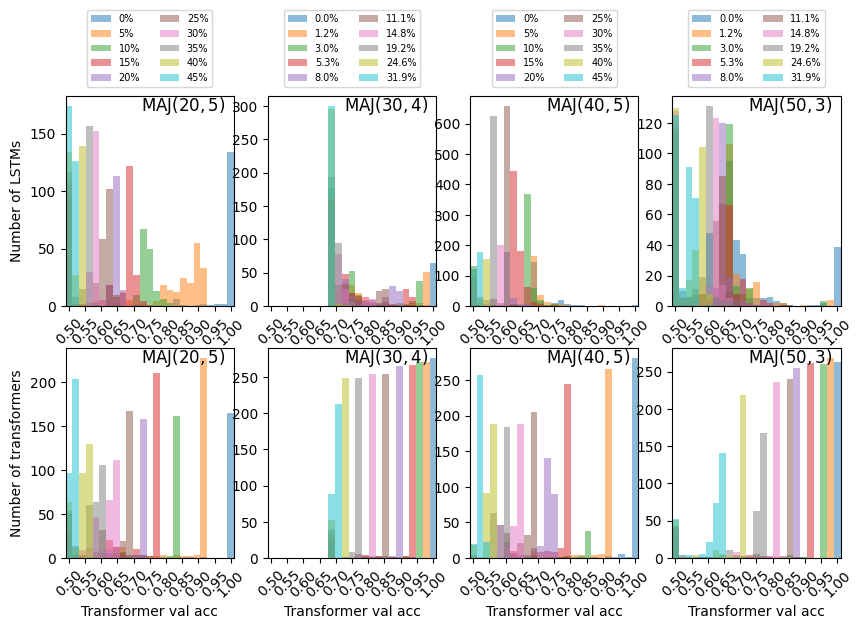

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(10, 6))


for j, idx in enumerate([1, 3, 0, 2]):
    df = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[idx]}.csv")
    nbins = 25
    bins = np.linspace(0.49, 1.01, nbins + 1)
    for bf in sorted(df['bf'].unique()):
        # make a histogram of val acc for this bf
        df_temp = df[df["bf"] == bf]
        cts, bins, _ = axes[0,j].hist(df_temp[df_temp["model"] == "RNN"]["val_acc"], bins=bins, alpha=0.5, label=f"{bf}%", density=False)
        axes[1,j].hist(df_temp[df_temp["model"] == "SAN"]["val_acc"][:300], bins=bins, alpha=0.5, label=f"{bf}%", density=False)
    axes[0,j].legend(ncol=2, loc="lower center", fontsize=7, bbox_to_anchor=(0.5, 1.02))
    for k in range(2):
        axes[k,j].text(0.7, .9, DATASET_NAMES[idx], ha="center", va="bottom", transform=axes[k,j].transAxes, fontsize=12)
        axes[k,j].set_xlim(0.49, 1.01)
        axes[k,j].set_xticks(np.linspace(0.5, 1, 11))
        axes[k,j].set_xticklabels([f"{i:.2f}" for i in np.linspace(0.5, 1, 11)], rotation=45, ha='center')
    axes[0,j].set_xlabel("LSTM val acc")
    axes[1,j].set_xlabel("Transformer val acc")


axes[0,0].set_ylabel("Number of LSTMs")
axes[1,0].set_ylabel("Number of transformers")

fig.savefig("figures/appendix_fig1.pdf", bbox_inches="tight")

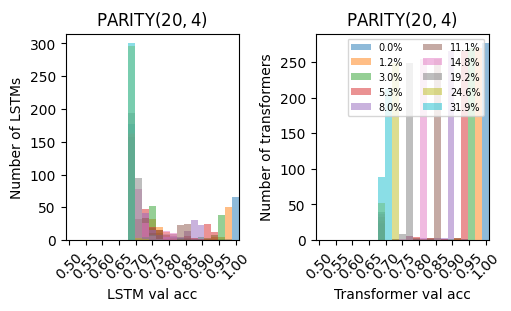

In [7]:
# repeat this procedure for sparity
idx_sparity = 4
bf_vals = BF_VALS[idx_sparity]
df_sparity = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
df_sparity_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")

fig, axes = plt.subplots(1, 2, figsize=(5, 3), constrained_layout=True)

nbins = 25
bins = np.linspace(0.49, 1.01, nbins + 1)
for bf in sorted(df_sparity['bf'].unique()):
    # make a histogram of val acc for this bf
    df_temp = df_sparity[df_sparity["bf"] == bf]
    cts, bins, _ = axes[0].hist(df_temp[df_temp["model"] == "RNN"]["val_acc"], bins=bins, alpha=0.5, label=f"{bf}%", density=False)
    axes[1].hist(df_temp[df_temp["model"] == "SAN"]["val_acc"][:300], bins=bins, alpha=0.5, label=f"{bf}%", density=False)


axes[1].legend(ncol=2, loc="upper right", fontsize=7, bbox_to_anchor=(1, 1))
# axes[0].text(0.7, .9, DATASET_NAMES[idx_sparity], ha="center", va="bottom", transform=axes[k].transAxes, fontsize=12)
for k in range(2):
    axes[k].set_title(DATASET_NAMES[idx_sparity])
    axes[k].set_xlim(0.49, 1.01)
    axes[k].set_xticks(np.linspace(0.5, 1, 11))
    axes[k].set_xticklabels([f"{i:.2f}" for i in np.linspace(0.5, 1, 11)], rotation=45, ha='center')
axes[0].set_xlabel("LSTM val acc")
axes[1].set_xlabel("Transformer val acc")


axes[0].set_ylabel("Number of LSTMs")
axes[1].set_ylabel("Number of transformers")
fig.savefig("figures/appendix_fig2.pdf", bbox_inches="tight")


### Make figure 1

In [8]:
dfs_all_fig1 = []
dfs_ana_fig1 = []
bf_vals_fig1 = []
for j in range(3):
    bf_vals = BF_VALS[j]
    df_all = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
    df_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")
    dfs_all_fig1.append(df_all)
    dfs_ana_fig1.append(df_ana)
    bf_vals_fig1.append(bf_vals)

j = 4
bf_vals = BF_VALS[j]
df_sparity = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}.csv")
df_sparity_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[j]}_ana.csv")
dfs_all_fig1.append(df_sparity)
dfs_ana_fig1.append(df_sparity_ana)
bf_vals_fig1.append(bf_vals)

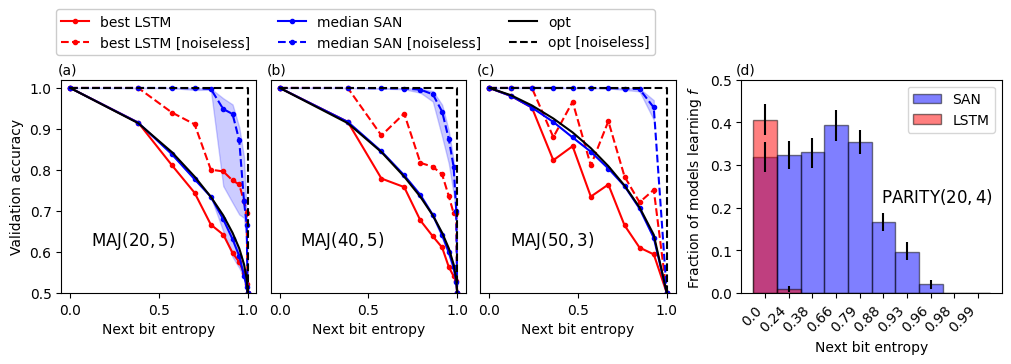

In [16]:
from mindreadingautobots.analysis.analysis_config import SPREADSHEET_NAMES, BF_VALS, NAME_TEMPLATES, DATASET_NAMES, spreadsheet_to_dataframe
from mindreadingautobots.analysis.plotting import make_san_vs_rnn_plot
from matplotlib.pyplot import setp

plt.close('all')
# fig, axes = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=False)
fig = plt.figure(figsize=(10, 3), constrained_layout=True)
gs = fig.add_gridspec(1, 4, width_ratios=[3, 3, 3, 4])
axes = gs.subplots()

# majority error plots
for ax_idx, j in enumerate([1,0,2]):
    apply_labels = True if ax_idx == 0 else False
    # For shared y-axis, always use axes[0] as the y-axis reference for axes[0:3]
    ax = axes[ax_idx]
    # Read the CSV file into a DataFrame
    df_all = dfs_all_fig1[j]
    df_ana = dfs_ana_fig1[j]
    bf_vals = bf_vals_fig1[j]
    # Pass sharey_ax to make_san_vs_rnn_plot if your plotting function supports it,
    # otherwise, set sharey manually after plotting
    ax = make_san_vs_rnn_plot(df_all, df_ana, bf_vals, ax, mode='entropy', apply_labels=apply_labels)
    ax.text(0.15, 0.3, DATASET_NAMES[j], ha='left', va='top', fontsize=12, transform=ax.transAxes)

axes[0].set_ylabel('Validation accuracy')
fig.legend(prop={'size': 10}, framealpha=1, ncol=3, loc='lower left', bbox_to_anchor=(.05, 1.01), borderaxespad=0.)

# New figure: do sparse parity
sparity_axis = 3
df_sparity = dfs_all_fig1[sparity_axis]
df_sparity_ana = dfs_ana_fig1[sparity_axis]
bf_vals_sparity = bf_vals_fig1[sparity_axis]
entropies = df_sparity_ana["entropy"].values.flatten()
for i, bf in enumerate(bf_vals_sparity):
    df1 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "RNN"]
    df2 = df_sparity.loc[df_sparity["bf"] == bf].loc[df_sparity["model"] == "SAN"]

    mle_noiseless = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noiseless"].values.flatten()
    mle_noisy = df_sparity_ana.loc[df_sparity_ana["bf"] == bf/100]["mle_noisy"].values.flatten()
    epsilon = 0.01
    # compute fractions of models that achieved MLE performance
    ci = 80

    san_val_frac, san_val_bounds = bootstrap_fraction_in_range(df2['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    # san_noiseless_val_frac, san_noiseless_bounds = bootstrap_fraction_in_range(df2['noiseless_val_acc'].values, mle_noisy)
    rnn_val_frac, rnn_val_bounds = bootstrap_fraction_in_range(df1['val_acc'].values, mle_noisy, delta=0.01, n_boot=5000, ci=ci)
    # rnn_noiseless_val_frac, rnn_noiseless_val_bounds = bootstrap_fraction_in_range(df1['noiseless_val_acc'].values, mle_noiseless)
    
    width = 1
    axes[sparity_axis].bar(i, san_val_frac, width=width, color='b', alpha=0.5, label=('SAN' if i == 0 else None), align='center', edgecolor='k', yerr=san_val_bounds)
    axes[sparity_axis].bar(i, rnn_val_frac, width=width, color='r', alpha=0.5, label=('LSTM' if i == 0 else None), align='center', edgecolor='k', yerr=rnn_val_bounds)


entropy_rounded = np.round(entropies, 2)
axes[sparity_axis].set_xticks(range(len(bf_vals_sparity)), entropy_rounded, rotation=45, ha='right')
axes[sparity_axis].set_xlabel('Next bit entropy')
axes[sparity_axis].set_ylabel(r'Fraction of models learning $f$')
axes[sparity_axis].legend()
axes[sparity_axis].text(0.75, 0.5, DATASET_NAMES[4], ha='center', va='top', fontsize=12, transform=axes[sparity_axis].transAxes)

for ax in axes[:3]:
    ax.set_ylim(0.5, 1.02)
    # ax.sharey(axes[0])
for ax in axes[1:3]:
    setp(ax, ylabel='', yticks=[],yticklabels=[])


axes[sparity_axis].set_ylim(0, 0.5)

# Add subplot labels (a) through (d)
for i, ax in enumerate(axes):
    ax.text(-0.02, 1.03, f'({chr(97+i)})', transform=ax.transAxes, fontsize=10)


plt.savefig(f"./figures/fig1.pdf", dpi=300, bbox_inches='tight')

The MAJ(30, 4) is actually a great transition piece for going from the $f = f_N^*$ functions to the $f \neq f_N^*$ functions